In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import MDS
from scipy.ndimage import gaussian_filter1d
from scipy.stats import entropy

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

RAND = 0
RESP = (50,220)
BASE = (-50,0)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
BASE = slice(ONSET + BASE[0], ONSET + BASE[1])

In [24]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('object_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

# df = pd.read_pickle('../../datasets/NNN/face_rdms.pkl')
# ROI_LIST = ['MF1_8_F', 'Unknown_19_F', 'MF1_7_F', 'MF1_9_F']
ROI_LIST = list(dat['roi'].unique())

print(dat['roi'].value_counts())

# cache = {
#     row['ROI']: {k: row[k] for k in df.columns if k != 'ROI'}
#     for _, row in df.iterrows()
# }

Unique face ROIs: ['MO2_21_O', 'Unknown_22_O', 'Unknown_11_O', 'MO1s1_4_O', 'Unknown_4_O', 'LPP4_1_O', 'LPP1_2_O', 'Unknown_15_O', 'CLC3_13_O', 'Unknown_14_O', 'AO2_24_O', 'PITP4_10_O', 'Unknown_6_O', 'MO1s2_5_O', 'Unknown_16_O', 'Unknown_26_O', 'AO5_25_O']
roi
MO2_21_O        1626
LPP4_1_O        1326
PITP4_10_O      1158
Unknown_11_O     989
MO1s2_5_O        899
CLC3_13_O        725
Unknown_14_O     595
Unknown_15_O     570
Unknown_6_O      489
Unknown_22_O     475
Unknown_4_O      419
AO5_25_O         393
Unknown_26_O     323
MO1s1_4_O        291
Unknown_16_O     248
LPP1_2_O         173
AO2_24_O         118
Name: count, dtype: int64


In [3]:
def geo_rdm(dat, roi, mode='top', step=5, k_max=200, metric='correlation'):
    rng = np.random.default_rng(RAND)
    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    scores = np.nanmean(X[:, RESP, :], axis=(0,1)) - np.nanmean(X[:, BASE, :], axis=(0,1))
    order = np.argsort(scores)[::-1] if mode == 'top' else rng.permutation(scores.size)

    # ================= choose the image-set bins to calculate RDMs ========
    sizes = [k for k in range(step, min(k_max, X.shape[2]) + 1, step)]
    # =================== ramping step size ================================ 
    # sizes = [k for k in range(1, 2*step)] + [k for k in range(2*step, min(k_max, X.shape[2])+1, step)]
    
    rdvs = []
    for k in tqdm(sizes):
        idx = order[:k]
        Ximg = X[:, :, idx] # (units, time, images)
        Xrdv = np.array([pdist(Ximg[:, t, :].T, metric='correlation') for t in range(Ximg.shape[1])])
        R = squareform(pdist(Xrdv, metric=metric))   # (time, time)
        rdvs.append(R)
    return sizes, rdvs

In [26]:
cache = {}
step = 1 # choose 1 so you can change it later on

for _roi in ROI_LIST:
    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    # sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)
    
    cache[_roi] = {
        "sizes_top": sizes_top,
        # "sizes_shuff": sizes_shuff,
        "top_rdms": top_rdms,
        # "shuff_rdms": shuff_rdms,
    }

df = pd.DataFrame([{**{'ROI': roi},
                    **vals} for roi,
                   vals in cache.items()])
df.to_pickle('../../datasets/NNN/object_rdms.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:05<00:00,  1.23s/it]


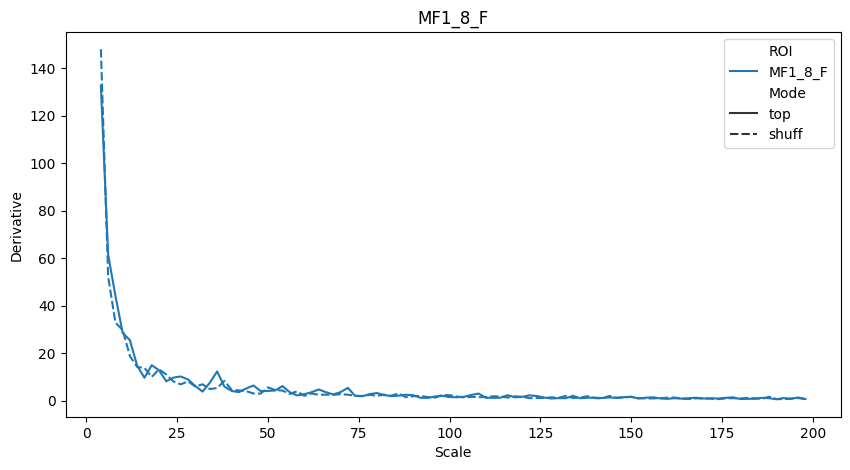

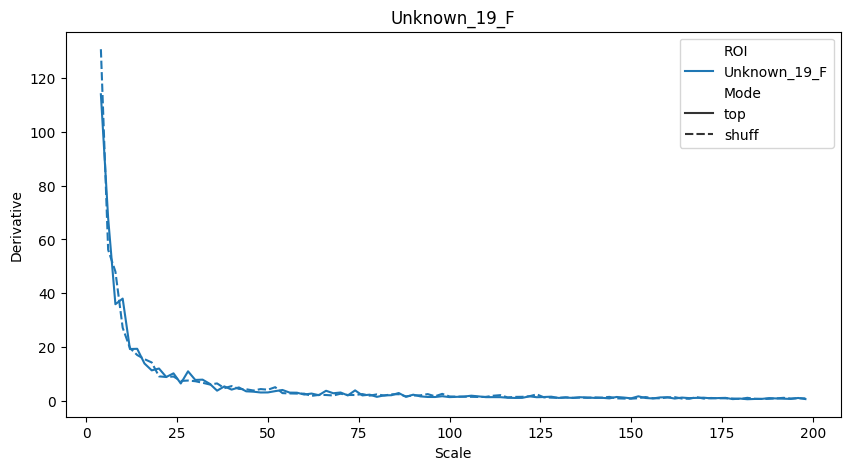

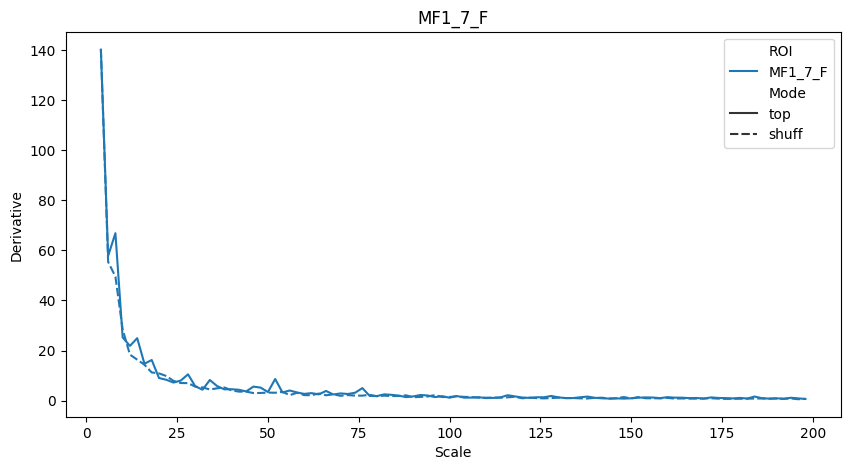

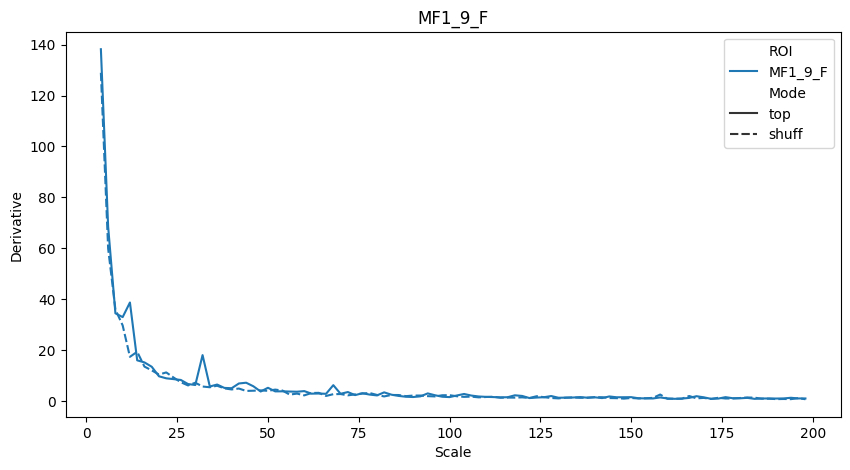

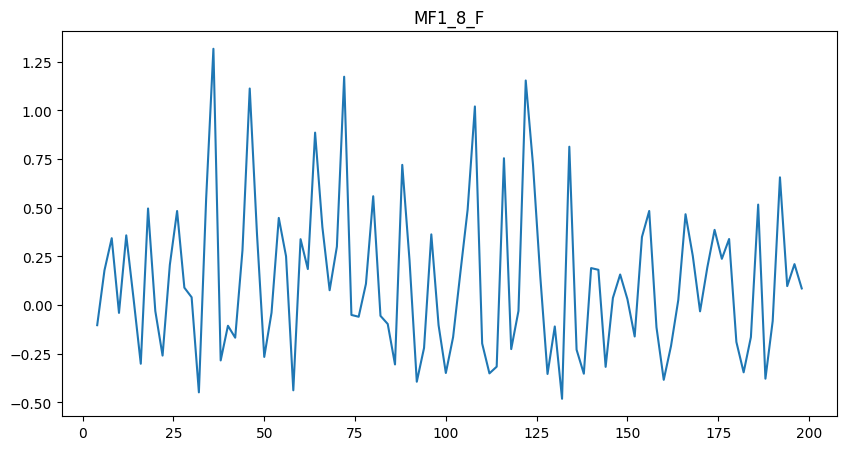

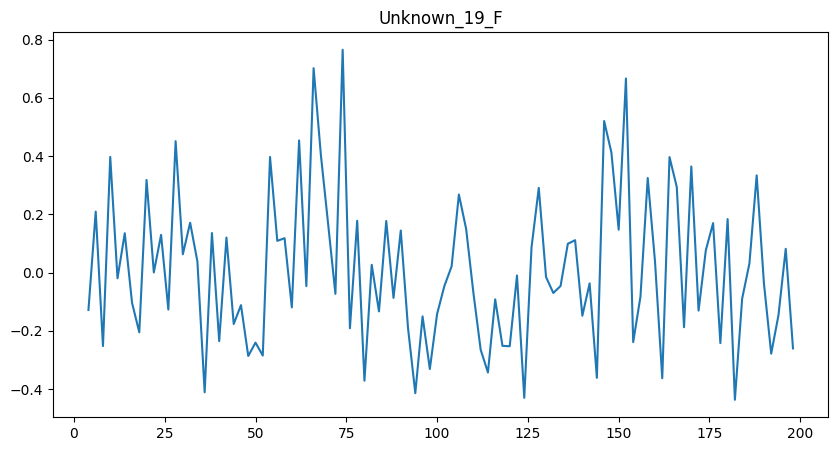

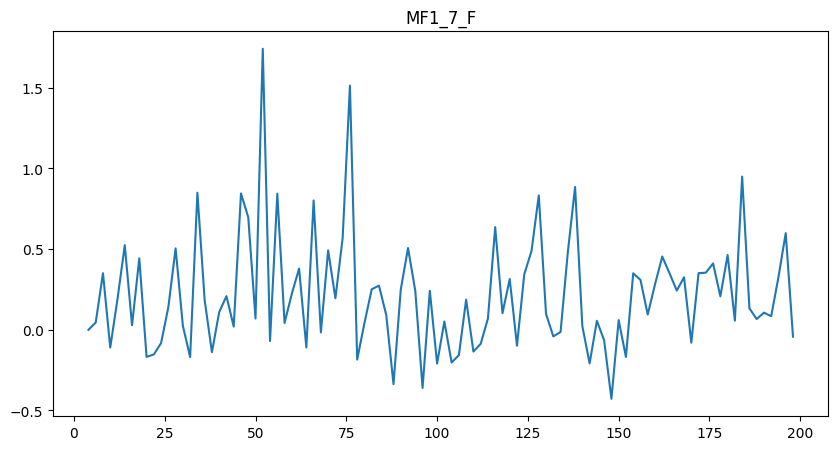

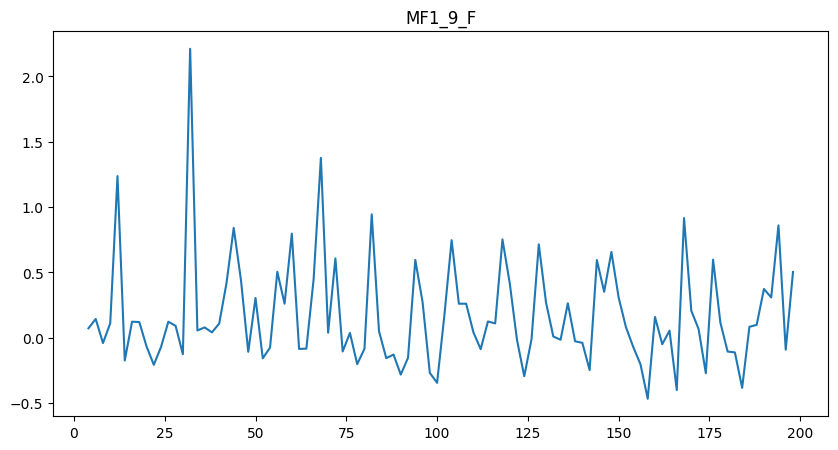

In [122]:
### MEAN SQUARED DIFFERENCE OVER SUCCESSIVE TIME POINTS

step = 2
cols = ['ROI', 'Scale', 'Derivative', 'Mode']
diffs = pd.DataFrame(columns=cols)
for _roi in ROI_LIST:
    roi_dict = cache[_roi]
    sizes = roi_dict['sizes_top']
    top_rdms = roi_dict['top_rdms']
    
    R0 = top_rdms[step][triu]
    for mode in ['top', 'shuff']:
        rdms = roi_dict[f'{mode}_rdms']
        triu = np.triu_indices_from(top_rdms[0], k=1)

        ## single time point RDM, or average over previous time step chunk
        # R0 = rdms[step][triu]
        R0 = np.mean(np.array([rdm[triu] for rdm in rdms[0:t]]), axis=0)
        
        for t in np.arange(1*step, len(rdms), step):
            prev = R0

            ## same as above
            # R0 = rdms[t-1][triu]
            R0 = np.mean(np.array([rdm[triu] for rdm in rdms[t:t+step]]), axis=0)
    
            ## difference metric for times t, t'
            diff = np.sqrt(np.sum((R0 - prev)**2))     
            # diff = np.sqrt(np.sum((R0)**2))
            # diff = 1 - spearmanr(R0, prev).statistic
    
            diffs.loc[len(diffs)] = {'ROI': _roi, 'Scale': sizes[t-1], 'Derivative': diff, 'Mode': mode}
            
for r in ROI_LIST:
    fig,ax = plt.subplots(1,1, figsize=(10,5))
    sns.lineplot(diffs[diffs['ROI']==r], x='Scale', y='Derivative', hue='ROI', style='Mode', ax=ax)
    ax.set_title(r)
    plt.show()

for r in ROI_LIST:
    fig,ax = plt.subplots(1,1, figsize=(10,5))
    top_diff = diffs[(diffs['ROI']==r) & (diffs['Mode']=='top')]['Derivative']
    shuff_diff = diffs[(diffs['ROI']==r) & (diffs['Mode']=='shuff')]['Derivative']

    d = (top_diff.values-shuff_diff.values) / shuff_diff.values
    
    sns.lineplot(x=np.arange(1*step, len(rdms), step), y=d, ax=ax)
    ax.set_title(r)
    plt.show()

  0%|                                                                                                                                                                           | 0/200 [00:00<?, ?it/s]/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_12733/930547558.py:15: RuntimeWarning: Mean of empty slice
  out.append(np.nanmean(corrs))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:55<00:00,  1.18s/it]


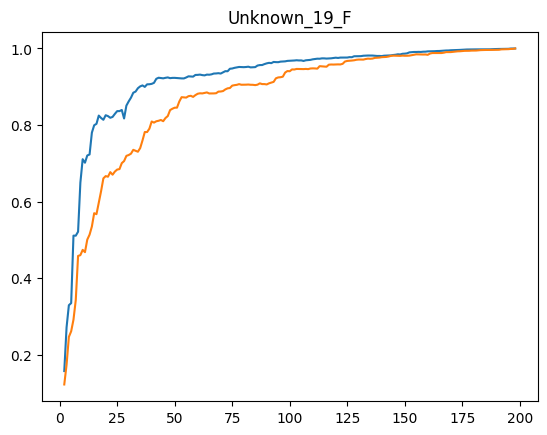

  0%|                                                                                                                                                                           | 0/200 [00:00<?, ?it/s]/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_12733/930547558.py:15: RuntimeWarning: Mean of empty slice
  out.append(np.nanmean(corrs))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:49<00:00,  1.15s/it]


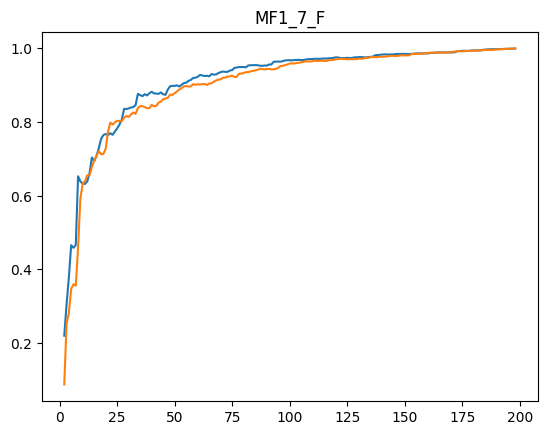

In [71]:
### LOOK AT AUTOCORRELATION OVER TIME?

def rdm_autocorr(rdms):
    triu = np.triu_indices_from(rdms[0], k=1)
    T = len(rdms)
    R = np.vstack([r[triu] for r in rdms])  # (T, features)

    out = []
    for t in tqdm(range(T)):
        r_t = R[t]
        future = R[t+1:]
        if len(future)==0:
            out.append(np.nan)
            continue
        corrs = np.array([spearmanr(r_t, f).statistic for f in future])
        out.append(np.nanmean(corrs))
    return np.array(out)

for _roi in ['Unknown_19_F', 'MF1_7_F',]:
    roi_dict = cache[_roi]
    auto = rdm_autocorr(roi_dict['top_rdms'])
    shuff = rdm_autocorr(roi_dict['shuff_rdms'])
    
    fig,ax = plt.subplots(1,1)
    sns.lineplot(auto, ax=ax)
    sns.lineplot(shuff, ax=ax)
    
    ax.set_title(_roi)
    plt.show()

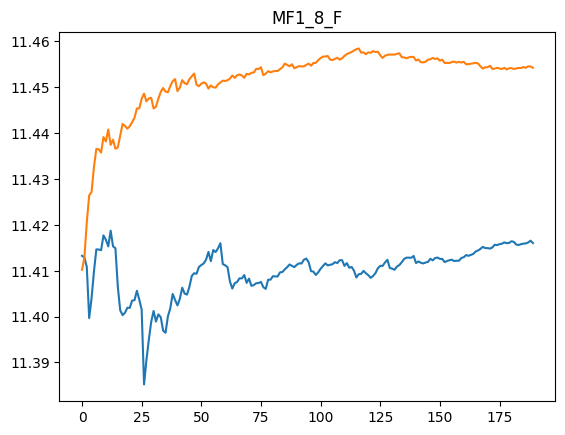

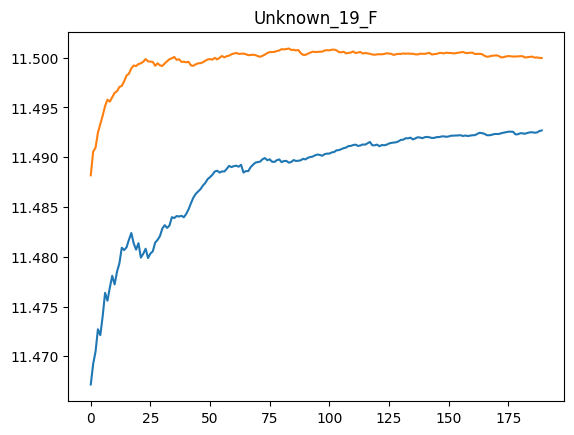

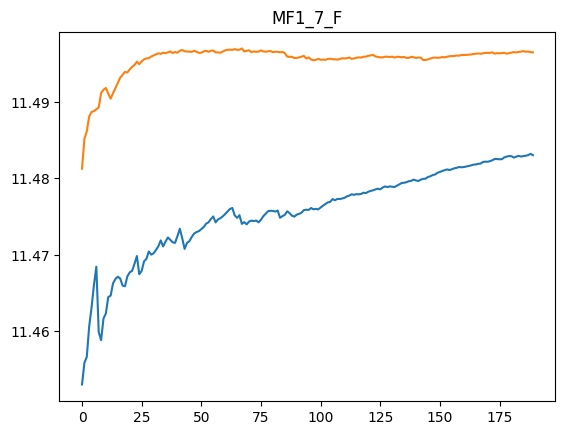

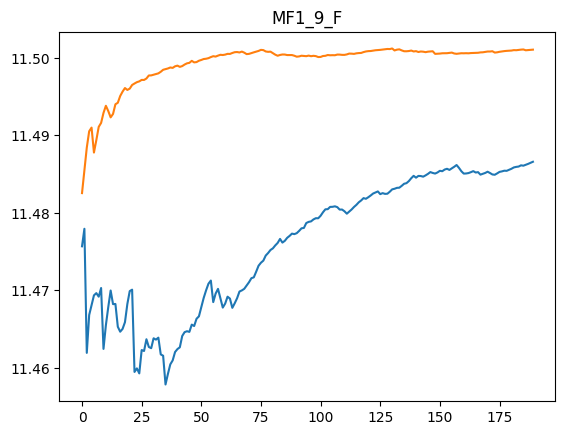

In [77]:
### MAYBE ENTROPY OF RDM?

def rdm_entropy(rdms):
    triu = np.triu_indices_from(rdms[0], k=1)
    H = []
    for R in rdms[10:]:
        v = np.abs(R[triu])
        v = v / v.sum()
        H.append(entropy(v))
    return np.array(H)

for _roi in ROI_LIST:
    roi_dict = cache[_roi]
    auto = rdm_entropy(roi_dict['top_rdms'])
    shuff = rdm_entropy(roi_dict['shuff_rdms'])
    
    fig,ax = plt.subplots(1,1)
    sns.lineplot(auto, ax=ax)
    sns.lineplot(shuff, ax=ax)
    
    ax.set_title(_roi)
    plt.show()

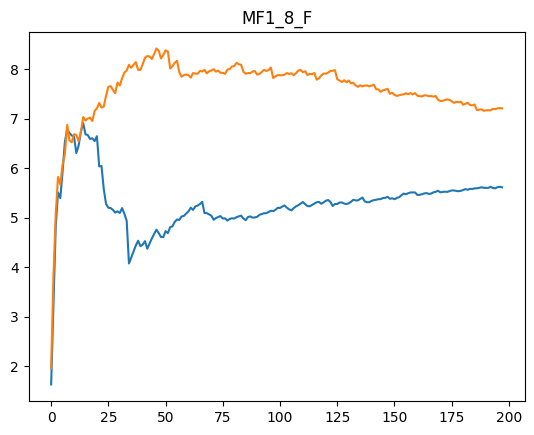

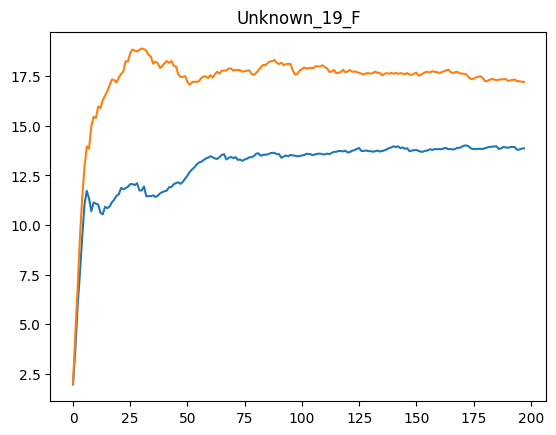

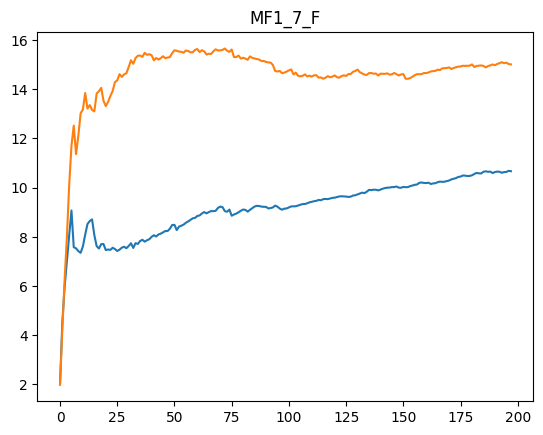

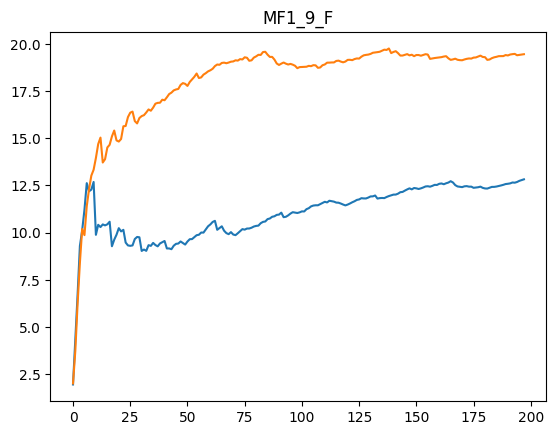

In [18]:
### EFFECTIVE DIMENSIONALITY ?

def effective_dim(R):
    S = -0.5 * R**2
    lam = np.linalg.eigvalsh(S)
    lam = np.clip(lam,0,None)
    return (lam.sum()**2) / (lam**2).sum()

def ed_over_time(rdms):
    return np.array([effective_dim(R) for R in rdms[2:]])

for _roi in ROI_LIST:
    roi_dict = cache[_roi]
    fig,ax = plt.subplots(1,1)
    sns.lineplot(ed_over_time(roi_dict['top_rdms']), ax=ax)
    sns.lineplot(ed_over_time(roi_dict['shuff_rdms']), ax=ax)
    ax.set_title(_roi)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:57<00:00,  4.43s/it]


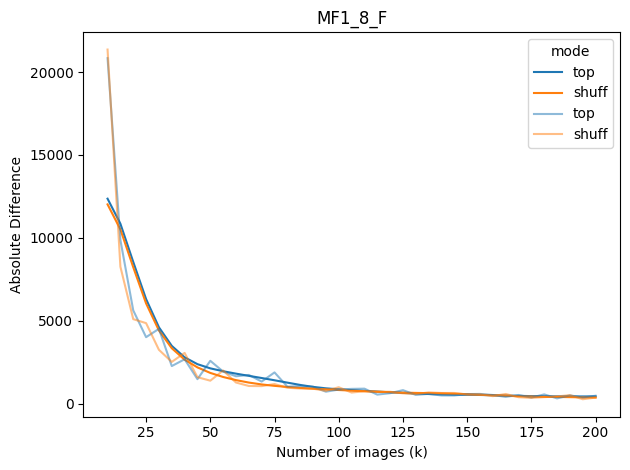

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:44<00:00,  1.12s/it]


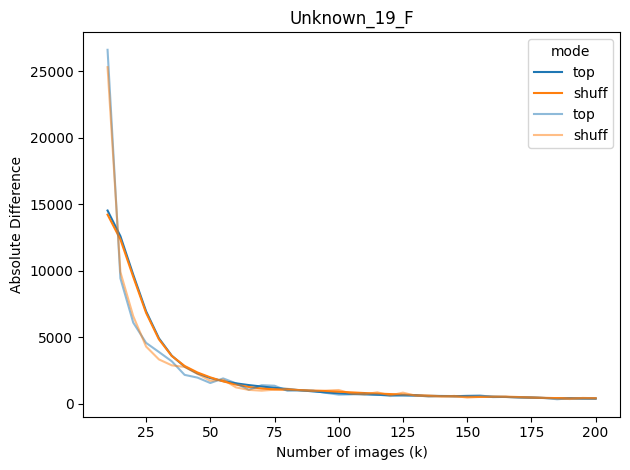

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:48<00:00,  1.21s/it]


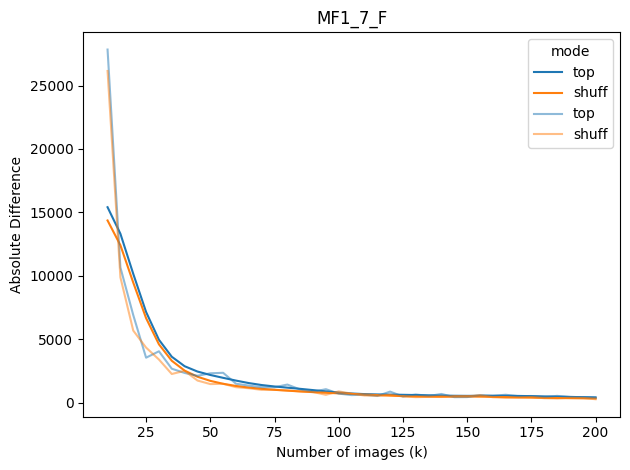

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:46<00:00,  1.17s/it]


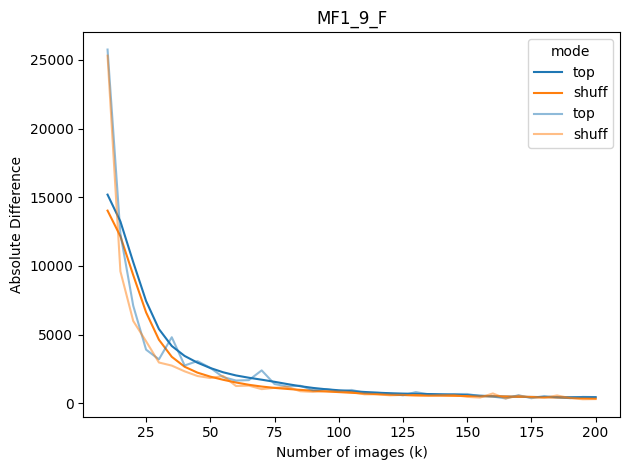

In [66]:
for _roi in ['MF1_8_F', 'Unknown_19_F', 'MF1_7_F', 'MF1_9_F']:
    step = 5

    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)
    
    def rdm_diffs(rdm_seq, start=2):
        R0 = rdm_seq[start]
        triu = np.triu_indices_from(R0, k=1)
        diffs = [
            # 1 - spearmanr(rdm_seq[i][triu], rdm_seq[i-1][triu])[0]
            np.sum(np.abs(rdm_seq[i][triu] - rdm_seq[i-1][triu]))
            for i in range(start, len(rdm_seq))
        ]
        ks = [sizes_top[i] for i in range(start, len(rdm_seq))]
        return ks, diffs
    
    k_top,   diffs_top   = rdm_diffs(top_rdms, start=1)
    k_shuff, diffs_shuff = rdm_diffs(shuff_rdms, start=1)
    
    df = pd.DataFrame({
        "k":     k_top + k_shuff,
        "diff":  diffs_top + diffs_shuff,
        "mode":  ["top"]*len(diffs_top) + ["shuff"]*len(diffs_shuff),
    })
    
    df["diff_smooth"] = df["diff"].groupby(df["mode"]).transform(
        lambda v: gaussian_filter1d(v, sigma=2)
    )
    
    sns.lineplot(data=df, x="k", y="diff_smooth", hue="mode")
    sns.lineplot(data=df, x="k", y="diff", hue="mode", alpha=0.5)
    
    plt.xlabel("Number of images (k)")
    plt.ylabel("Absolute Difference")
    plt.title(f'{_roi}')
    plt.tight_layout()
    plt.show()

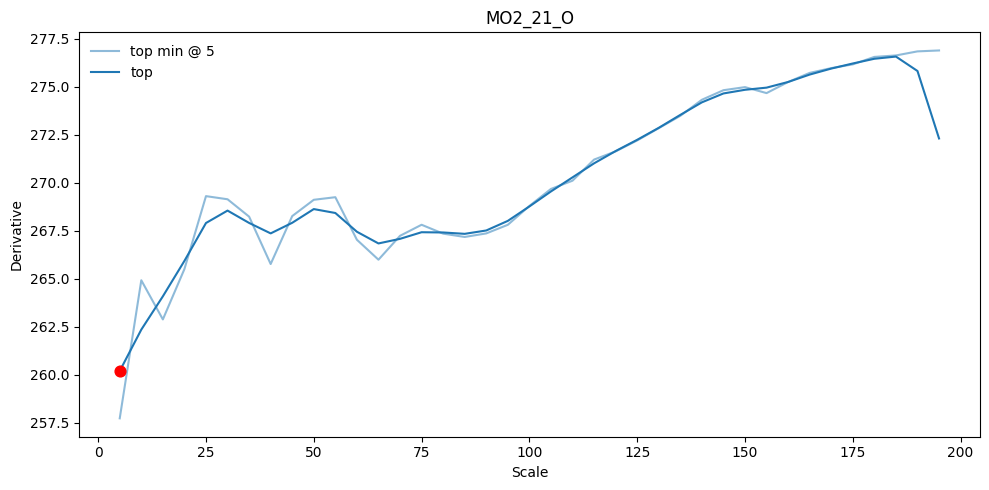

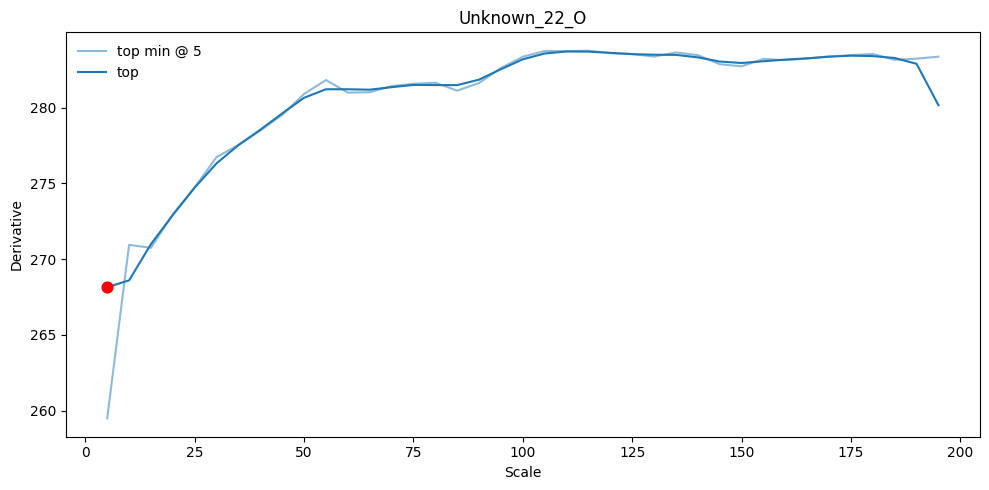

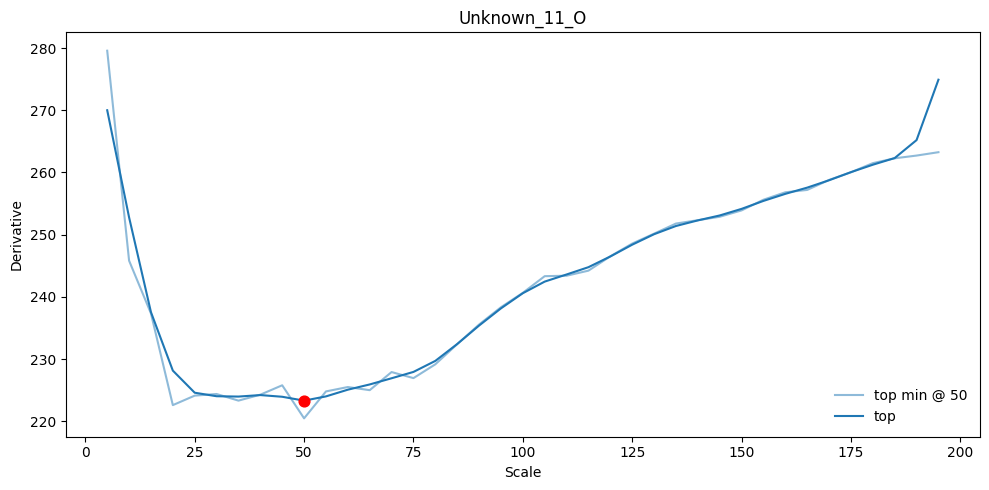

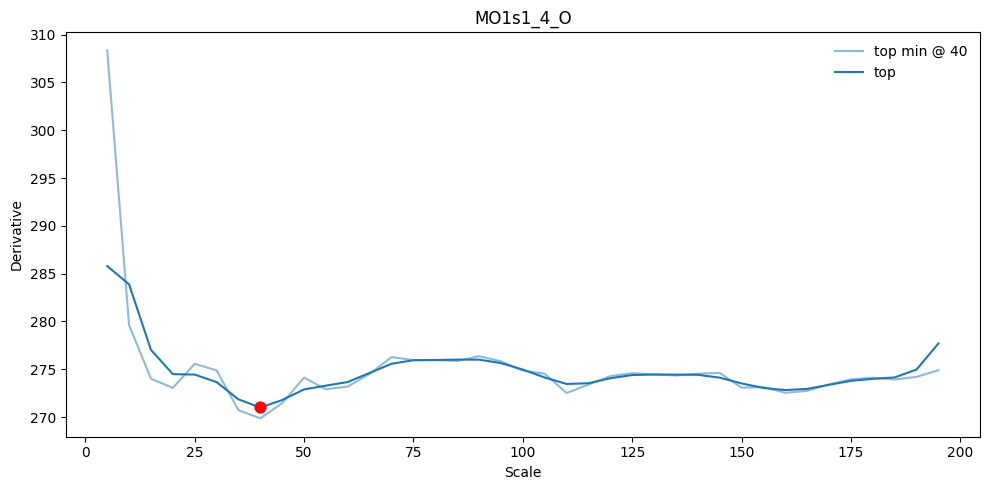

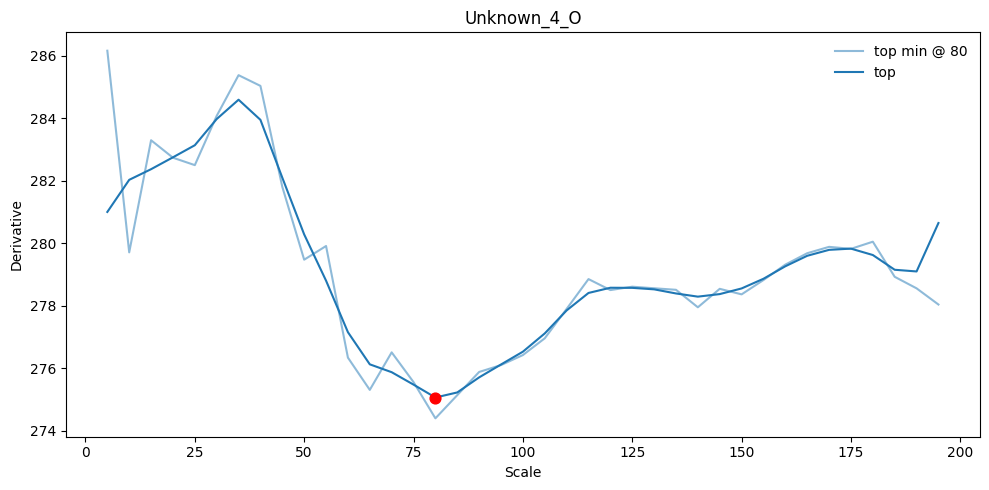

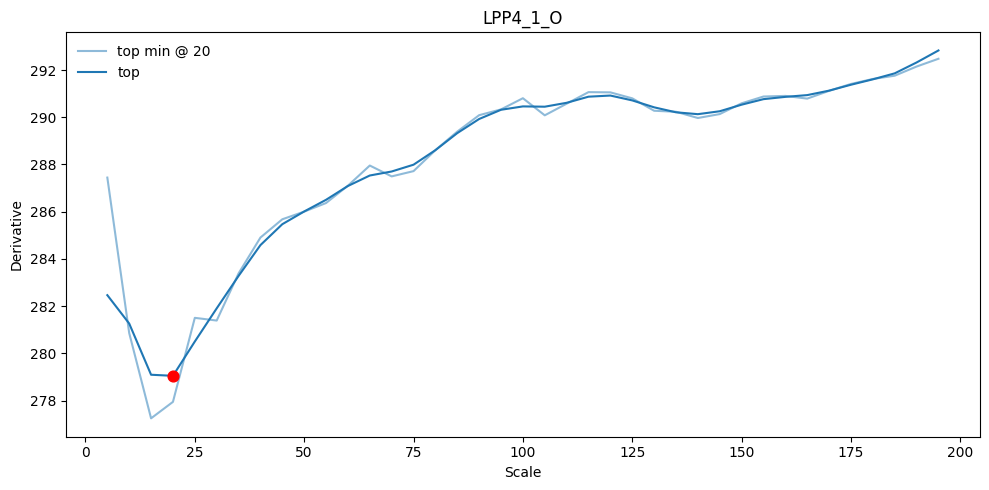

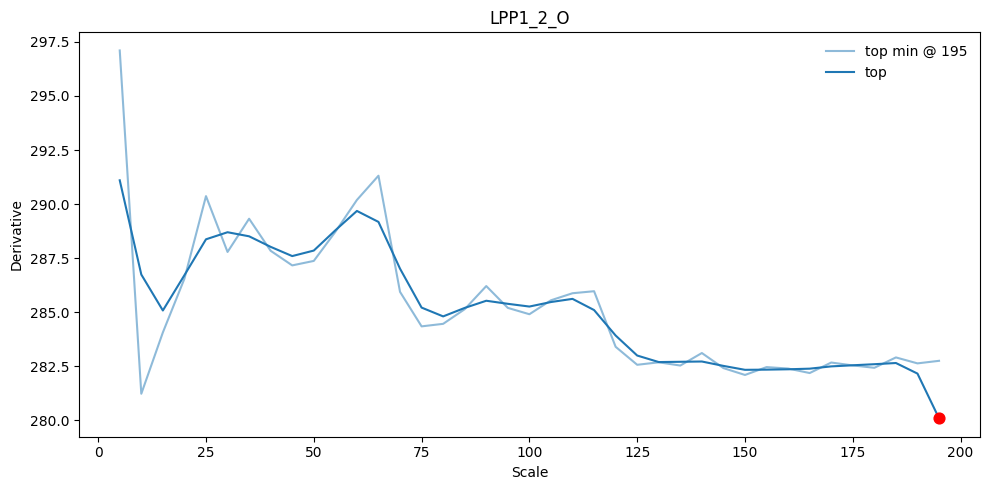

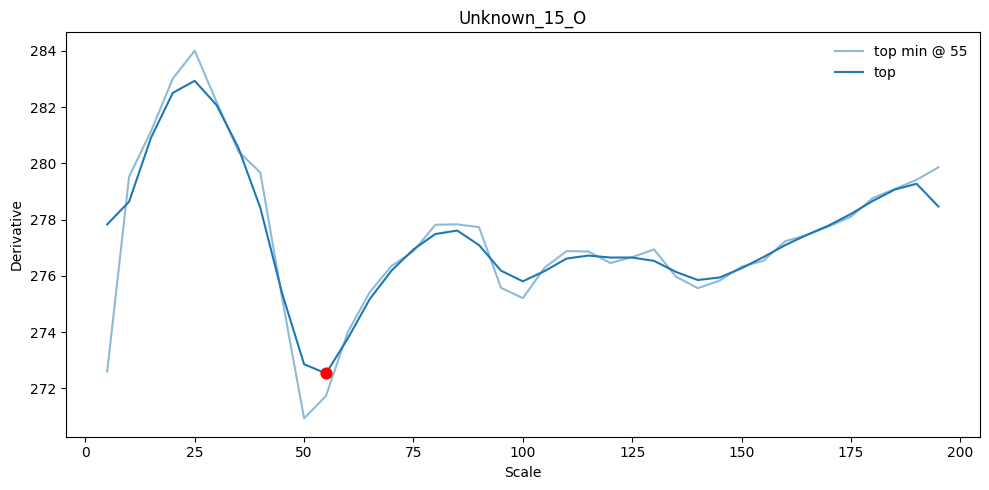

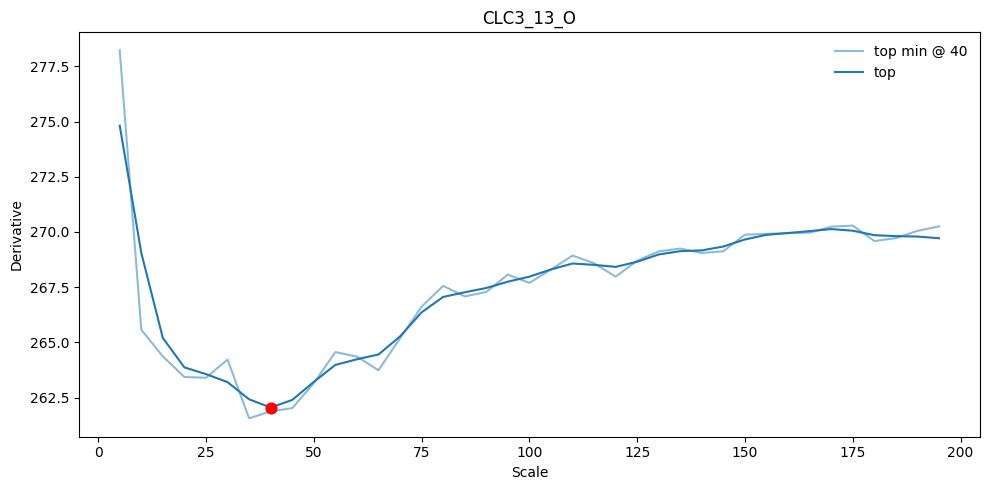

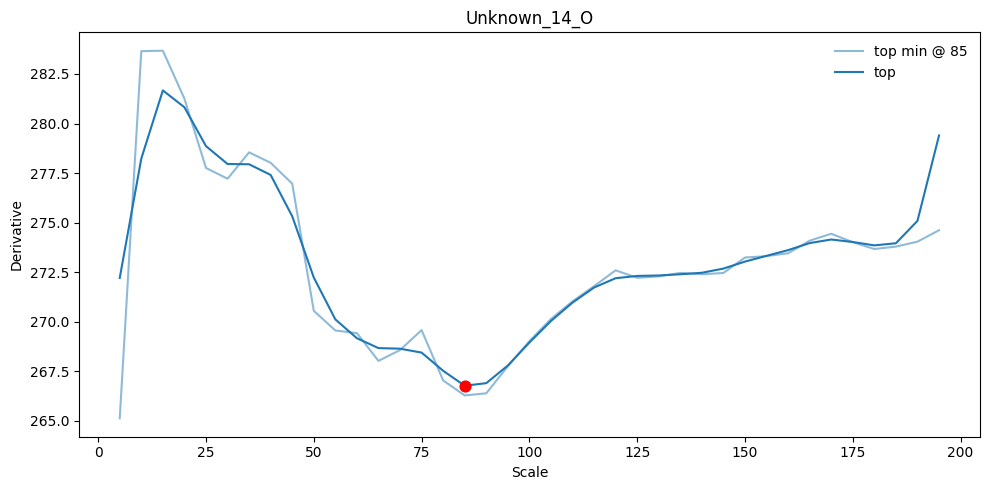

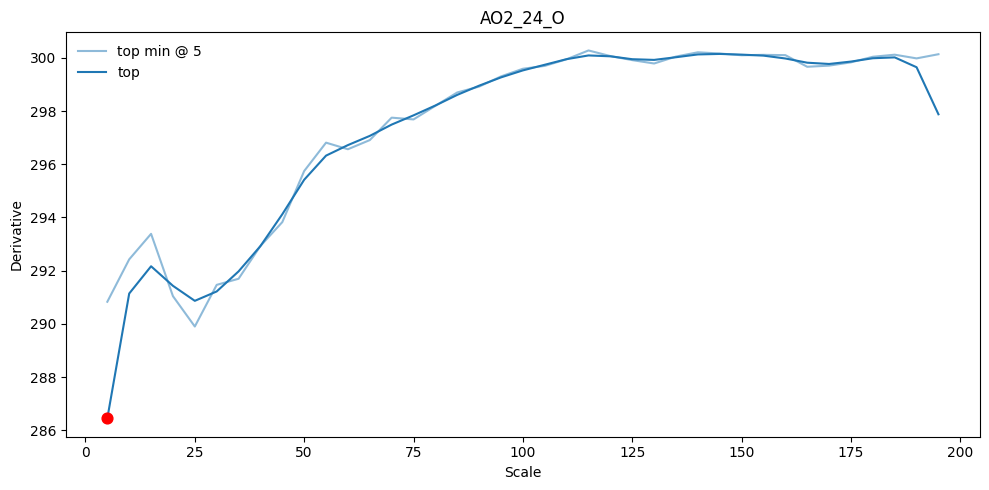

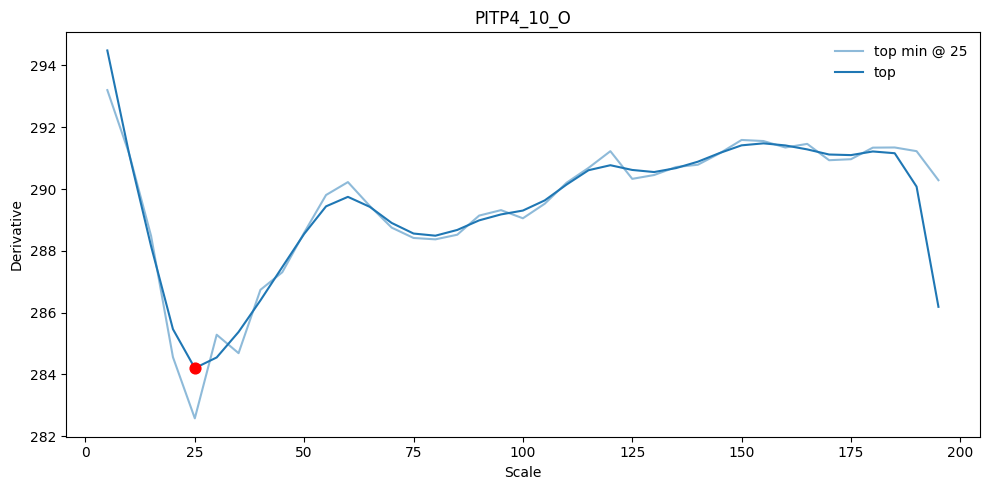

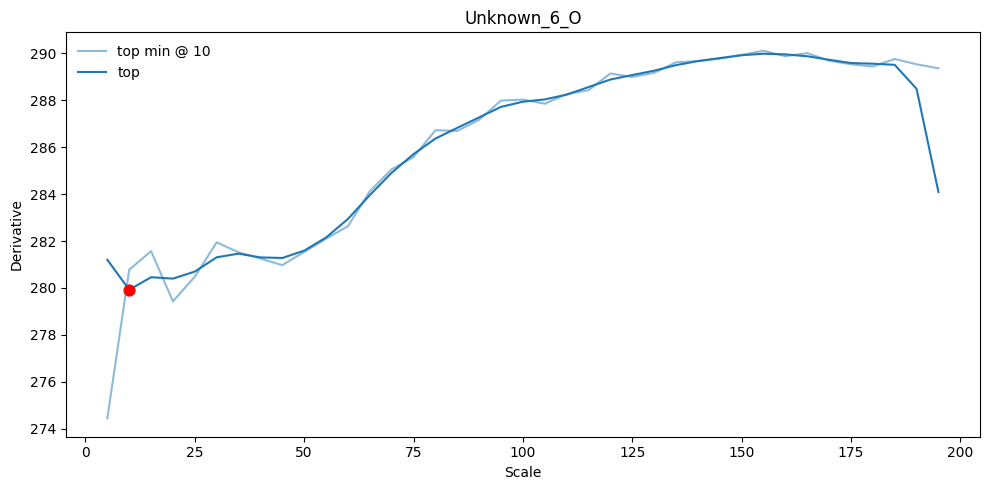

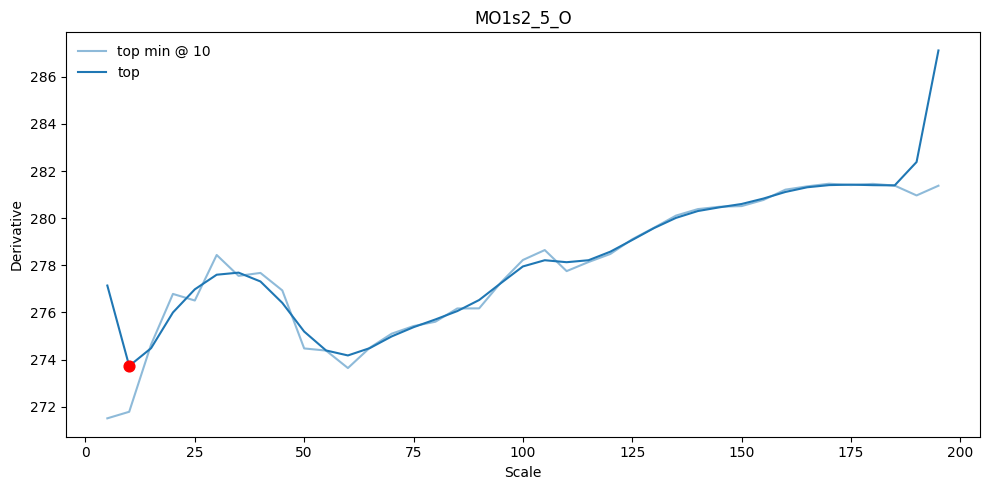

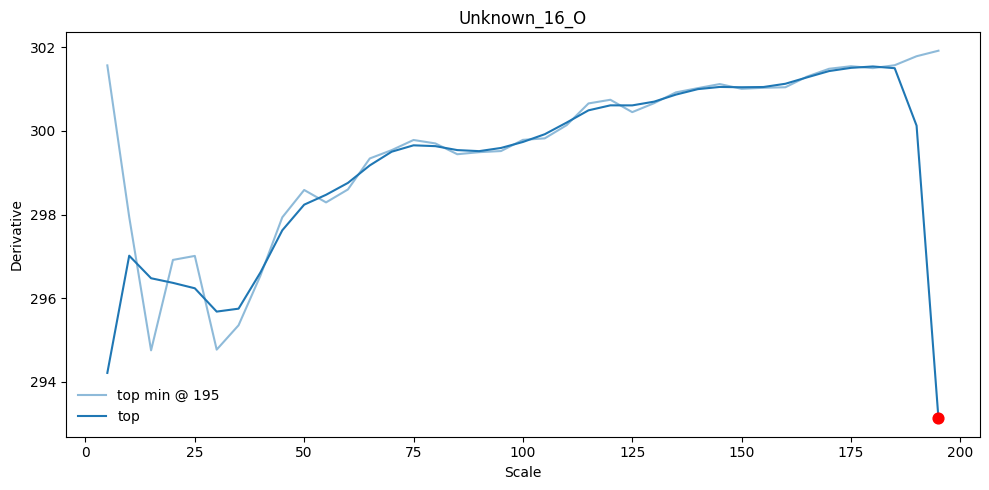

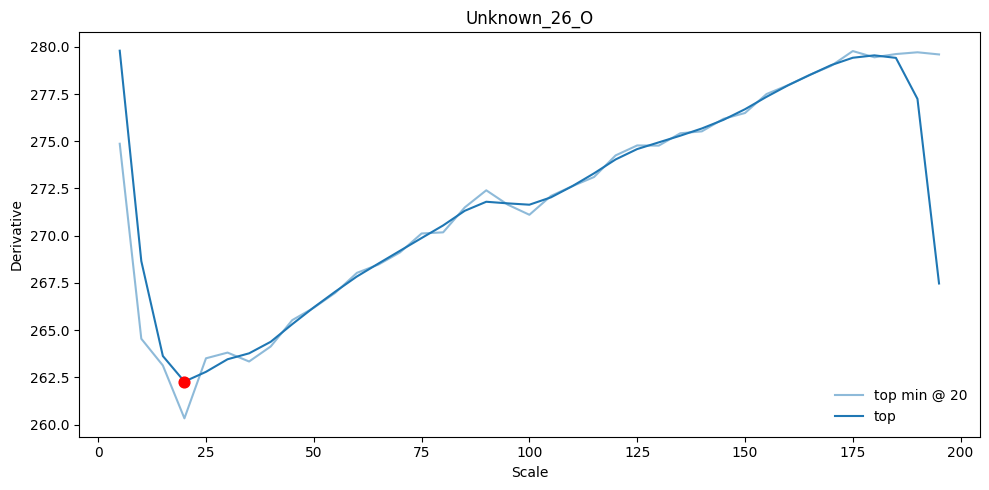

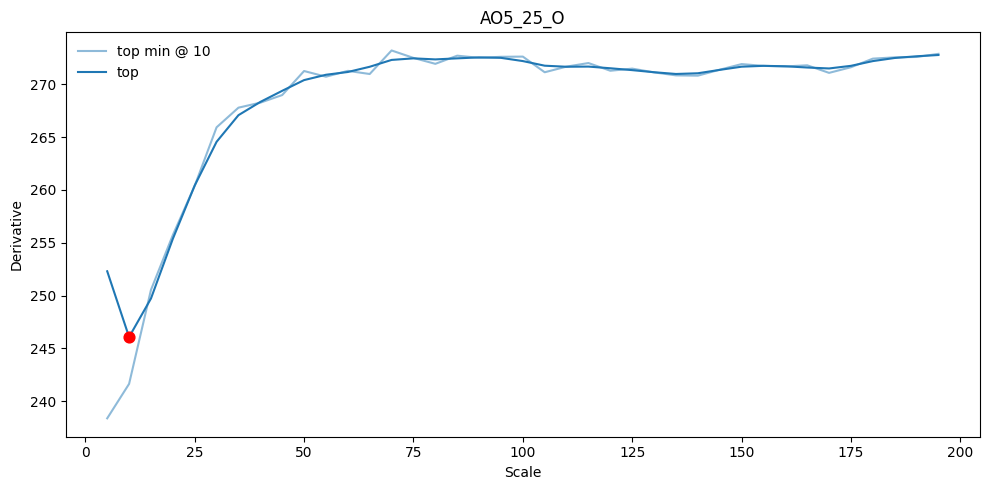

In [29]:
### ABS DISSIM FOR A SINGLE TIME POINT

step = 5
cols = ['ROI', 'Scale', 'Derivative', 'Mode']
diffs = pd.DataFrame(columns=cols)
for _roi in ROI_LIST:
    roi_dict = cache[_roi]
    sizes = roi_dict['sizes_top']
   
    for mode in ['top']: #, 'shuff']:
        rdms = roi_dict[f'{mode}_rdms']
        triu = np.triu_indices_from(rdms[0], k=1)

        ## single time point RDM, or average over previous time step chunk
        # R0 = rdms[step][triu]
        R0 = np.mean(np.array([rdm[triu] for rdm in rdms[0:step]]), axis=0) #######################################
        for t in np.arange(1*step, len(rdms), step):
            prev = R0
            ## same as above
            # R0 = rdms[t-1][triu]
            R0 = np.mean(np.array([rdm[triu] for rdm in rdms[t:t+step]]), axis=0) ######################################
    
            ## difference metric for times t, t'
            diff = np.sqrt(np.sum((R0)**2))
            # diff = 1 - spearmanr(R0, prev).statistic
    
            diffs.loc[len(diffs)] = {'ROI': _roi, 'Scale': sizes[t-1], 'Derivative': diff, 'Mode': mode}


diffs["diff_smooth"] = diffs["Derivative"].groupby(diffs["Mode"]).transform(
    lambda v: gaussian_filter1d(v, sigma=1)
)
mins = {}
for r in ROI_LIST:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    d = diffs[diffs['ROI'] == r]

    # main lineplot
    sns.lineplot(data=d, x='Scale', y='Derivative', hue='Mode', alpha=0.5, ax=ax)
    sns.lineplot(data=d, x='Scale', y='diff_smooth', hue='Mode', ax=ax)

    # add red dot + legend label for each Mode separately
    labels  = list(ax.get_legend_handles_labels()[1])

    for i, mode in enumerate(['top']): # enumerate(['top', 'shuff']):
        dm = d[(d['Mode'] == mode)]
        idx_min = dm['diff_smooth'].idxmin()
        if np.isnan(idx_min):
            continue
        x_min   = dm.loc[idx_min, 'Scale']
        y_min   = dm.loc[idx_min, 'diff_smooth']

        # draw red dot
        mins[r] = (x_min, y_min)
        h = ax.scatter(x_min, y_min, color='red', s=60, zorder=5)

        # label for legend
        labels[i] = f'{mode} min @ {int(x_min)}'

    ax.legend(ax.get_legend_handles_labels()[0], labels, frameon=False)
    ax.set_title(r)
    plt.tight_layout()
    plt.show()

import pickle 

with open('../../datasets/NNN/object_mins.pkl', 'wb') as f:
    pickle.dump(mins, f)

In [19]:
# EFFECTIVE DIMENSIONALITY
def effective_dimensionality(R):
    S = -0.5 * R**2
    lam = np.linalg.eigvalsh(S)
    lam = np.clip(lam, 0, None)
    return (lam.sum()**2) / (lam**2).sum()

cache = {}

for _roi in ['Unknown_19_F', 'MF1_7_F', 'MF1_9_F', 'MF1_8_F']:
    step = 5

    sizes_top,   top_rdms   = geo_rdm(dat, roi=_roi, mode='top',   step=step)
    sizes_shuff, shuff_rdms = geo_rdm(dat, roi=_roi, mode='shuff', step=step)

    def rdm_dim(rdm_seq, sizes):
        dims = [effective_dimensionality(R) for R in rdm_seq]
        return sizes, dims

    k_top,   dims_top   = rdm_dim(top_rdms,   sizes_top)
    k_shuff, dims_shuff = rdm_dim(shuff_rdms, sizes_shuff)

    df = pd.DataFrame({
        "k":   k_top + k_shuff,
        "dim": dims_top + dims_shuff,
        "mode": ["top"]*len(dims_top) + ["shuff"]*len(dims_shuff),
    })

    df["dim_smooth"] = df["dim"].groupby(df["mode"]).transform(
        lambda v: gaussian_filter1d(v, sigma=2)
    )

    cache[_roi] = {
        "sizes_top": sizes_top,
        "sizes_shuff": sizes_shuff,
        "top_rdms": top_rdms,
        "shuff_rdms": shuff_rdms,
    }

    sns.lineplot(data=df, x="k", y="dim_smooth", hue="mode")
    sns.lineplot(data=df, x="k", y="dim", hue="mode", alpha=0.4)

    plt.xlabel("Number of images (k)")
    plt.ylabel("Effective dimensionality")
    plt.title(f"{_roi}")
    plt.tight_layout()
    plt.show()

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 32/40 [00:24<00:06,  1.32it/s]


KeyboardInterrupt: 